In [14]:
import torch
print(torch.cuda.is_available())


True


Data Preprocessing

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
url = 'https://p19-bot-sign-sg.ciciai.com/tos-alisg-i-b2l6bve69y-sg/ca602a4dd2e04e6ea717f6548ca51fa6.csv~tplv-b2l6bve69y-image.image?rk3s=68e6b6b5&x-expires=1719744177&x-signature=sdxk9fyq5FsGMaG9rN5e5sU%2FFhk%3D'
data = pd.read_csv(url)

# Handling Missing Values
data.fillna(data.mean(), inplace=True)

# Encoding Categorical Variables
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# Normalizing Numerical Features
numerical_cols = data.columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

Sampling

In [3]:
from sklearn.model_selection import train_test_split

#load data into gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Split the data into training and testing sets

X = data.drop(columns=['Diabetes'])
y = data['Diabetes']
y = y.apply(lambda x: 1 if x > 0 else 0)





***LOGISTIC REGRESSION***

In [16]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

Build the model (logistic regresion)

In [20]:
import torch.nn as nn
import torch.optim as optim

# Define the Logistic Regression model using PyTorch
#running on gpu


class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]
lr_model = LogisticRegressionModel(input_dim)
lr_model.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(lr_model.parameters(), lr=0.01)

# Define number of epochs
num_epochs = 100

Model Training

In [21]:
# Train the model
def train_model(model, optimizer, criterion, X_train, y_train):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

model evaluation

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = outputs.round()
        y_test_numpy = y_test.numpy()
        predicted_numpy = predicted.numpy()
        y_prob = outputs.numpy()

        # Calculate accuracy
        accuracy = accuracy_score(y_test_numpy, predicted_numpy)
        
        # Calculate precision
        precision = precision_score(y_test_numpy, predicted_numpy)
        
        # Calculate sensitivity (recall)
        recall = recall_score(y_test_numpy, predicted_numpy)
        
        # Calculate F1 score
        f1 = f1_score(y_test_numpy, predicted_numpy)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test_numpy, predicted_numpy).ravel()

        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test_numpy, y_prob)
        
        return accuracy, precision, recall, f1, roc_auc, tn, fp, fn, tp

# Perform 100 evaluations using bootstrapping
num_evaluations = 100
metrics = []
best_accuracy = 0
best_model_state = None

In [23]:
from sklearn.utils import resample
import numpy as np

# Perform 100 evaluations using bootstrapping
num_evaluations = 100
metrics = []

for i in range(num_evaluations):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_tensor, y_tensor, n_samples=len(X_tensor), random_state=None)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=None)
    
    # Reinitialize the model parameters for each iteration
    lr_model = LogisticRegressionModel(input_dim)
    optimizer = optim.SGD(lr_model.parameters(), lr=0.01)
    
    # Train the model
    train_model(lr_model, optimizer, criterion, X_train, y_train)
    
    # Evaluate the model
    metrics.append(evaluate_model(lr_model, X_test, y_test))
    
    # Save the model
    torch.save(lr_model.state_dict(), f'logistic_regression_model_{i}.pth')

# Calculate average metrics
metrics_array = np.array(metrics)
mean_metrics = np.mean(metrics_array, axis=0)

# Print the average results
print(f'Average Accuracy: {mean_metrics[0]:.4f}')
print(f'Average Precision: {mean_metrics[1]:.4f}')
print(f'Average Sensitivity (Recall): {mean_metrics[2]:.4f}')
print(f'Average F1 Score: {mean_metrics[3]:.4f}')
print(f'Average ROC AUC: {mean_metrics[4]:.4f}')
print(f'Average Confusion Matrix: TP={mean_metrics[8]:.0f}, TN={mean_metrics[5]:.0f}, FP={mean_metrics[6]:.0f}, FN={mean_metrics[7]:.0f}')

Average Accuracy: 0.6818
Average Precision: 0.6939
Average Sensitivity (Recall): 0.6545
Average F1 Score: 0.6707
Average ROC AUC: 0.7502
Average Confusion Matrix: TP=4624, TN=5016, FP=2058, FN=2441


In [9]:
# Calculate mean and 95% confidence intervals for each metric
mean_metrics = np.mean(metrics_array, axis=0)
ci_lower = np.percentile(metrics_array, 2.5, axis=0)
ci_upper = np.percentile(metrics_array, 97.5, axis=0)

# Print the average results with confidence intervals
print(f'Average Accuracy: {mean_metrics[0]:.4f} (95% CI: {ci_lower[0]:.4f} - {ci_upper[0]:.4f})')
print(f'Average Precision: {mean_metrics[1]:.4f} (95% CI: {ci_lower[1]:.4f} - {ci_upper[1]:.4f})')
print(f'Average Sensitivity (Recall): {mean_metrics[2]:.4f} (95% CI: {ci_lower[2]:.4f} - {ci_upper[2]:.4f})')
print(f'Average F1 Score: {mean_metrics[3]:.4f} (95% CI: {ci_lower[3]:.4f} - {ci_upper[3]:.4f})')
print(f'Average ROC AUC: {mean_metrics[4]:.4f} (95% CI: {ci_lower[4]:.4f} - {ci_upper[4]:.4f})')
print(f'Average Confusion Matrix: TP={mean_metrics[8]:.0f} (95% CI: {ci_lower[8]:.0f} - {ci_upper[8]:.0f}), TN={mean_metrics[5]:.0f} (95% CI: {ci_lower[5]:.0f} - {ci_upper[5]:.0f}), FP={mean_metrics[6]:.0f} (95% CI: {ci_lower[6]:.0f} - {ci_upper[6]:.0f}), FN={mean_metrics[7]:.0f} (95% CI: {ci_lower[7]:.0f} - {ci_upper[7]:.0f})')

Average Accuracy: 0.6769 (95% CI: 0.6225 - 0.7153)
Average Precision: 0.6883 (95% CI: 0.6299 - 0.7364)
Average Sensitivity (Recall): 0.6531 (95% CI: 0.4968 - 0.8094)
Average F1 Score: 0.6663 (95% CI: 0.5717 - 0.7351)
Average ROC AUC: 0.7463 (95% CI: 0.6894 - 0.7897)
Average Confusion Matrix: TP=4614 (95% CI: 3535 - 5749), TN=4957 (95% CI: 4091 - 5711), FP=2116 (95% CI: 1416 - 3019), FN=2451 (95% CI: 1353 - 3586)


***SVM MODEL***

Model Building

In [10]:
class SVMModel(nn.Module):
    def __init__(self, input_dim):
        super(SVMModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x)
    
# Initialize the models, loss functions, and optimizers
input_dim = X_train.shape[1]
svm_model = SVMModel(input_dim)
criterion_svm = nn.HingeEmbeddingLoss()
optimizer_svm = optim.SGD(svm_model.parameters(), lr=0.01)

Model Training

In [11]:
# Training the SVM model
for epoch in range(num_epochs):
    svm_model.train()
    optimizer_svm.zero_grad()
    outputs = svm_model(X_train_tensor)
    outputs = torch.sign(outputs)
    loss = criterion_svm(outputs, 2 * y_train_tensor - 1)  # Convert 0/1 to -1/1
    loss.backward()
    optimizer_svm.step()
    
    if (epoch+1) % 10 == 0:
        print(f'SVM - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Save the model
torch.save(svm_model.state_dict(), 'svm_model.pth')

NameError: name 'X_train_tensor' is not defined

Model Evalutaion

In [31]:
svm_model.eval()
with torch.no_grad():
    svm_outputs = svm_model(X_test_tensor)
    svm_pred = (svm_outputs >= 0).float().numpy().flatten()  # Convert to binary 0 and 1
    svm_prob = (svm_outputs - svm_outputs.min()) / (svm_outputs.max() - svm_outputs.min())  # Normalize to [0, 1]
    svm_prob = svm_prob.numpy().flatten()

def evaluate_model(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return accuracy, precision, recall, f1, roc_auc, tn, fp, fn, tp

# Evaluate the SVM model
svm_accuracy, svm_precision, svm_recall, svm_f1, svm_roc_auc, svm_tn, svm_fp, svm_fn, svm_tp = evaluate_model(y_test, svm_pred, svm_prob)

# Print the results
print(f'SVM - Accuracy: {svm_accuracy:.4f}')
print(f'SVM - Precision: {svm_precision:.4f}')
print(f'SVM - Sensitivity (Recall): {svm_recall:.4f}')
print(f'SVM - F1 Score: {svm_f1:.4f}')
print(f'SVM - Confusion Matrix: TP={svm_tp}, TN={svm_tn}, FP={svm_fp}, FN={svm_fn}')
print(f'SVM - ROC AUC: {svm_roc_auc:.4f}')


SVM - Accuracy: 0.4611
SVM - Precision: 0.4412
SVM - Sensitivity (Recall): 0.3040
SVM - F1 Score: 0.3600
SVM - Confusion Matrix: TP=2143, TN=4376, FP=2714, FN=4906
SVM - ROC AUC: 0.4209


***compare 2 model***

Cross validation

In [38]:
#perform cross validation
from sklearn.model_selection import cross_val_score


# Define a function to perform cross-validation
def cross_validate(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return scores

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Perform cross-validation for Logistic Regression
lr_scores = cross_validate(LogisticRegression(), X, y)
print(f'Logistic Regression Cross-Validation Scores: {lr_scores}')

# Perform cross-validation for SVM
svm_scores = cross_validate(SVC(), X, y)
print(f'SVM Cross-Validation Scores: {svm_scores}')

Logistic Regression Cross-Validation Scores: [0.73810029 0.74757762 0.74713538 0.75166219 0.75060122]
SVM Cross-Validation Scores: [0.74121225 0.74658745 0.74840854 0.75194511 0.74968171]


Confidence intervals

In [ ]:
# Confidence Intervals
from scipy.stats import sem
import numpy as np

logistic_metrics = [lr_accuracy, lr_precision, lr_recall, lr_f1, lr_roc_auc, lr_tn, lr_fp, lr_fn, lr_tp]
svm_metrics = [svm_accuracy, svm_precision, svm_recall, svm_f1, svm_roc_auc, svm_tn, svm_fp, svm_fn, svm_tp]

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = sem(data)
    margin_of_error = se * 1.96  # For 95% confidence interval
    return mean, margin_of_error

logistic_ci = {metric: confidence_interval([logistic_metrics[i]]) for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])}
svm_ci = {metric: confidence_interval([svm_metrics[i]]) for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])}

print('Logistic Regression Confidence Intervals:')
print(logistic_ci)
print('SVM Confidence Intervals:')
print(svm_ci)

NameError: name 'np' is not defined

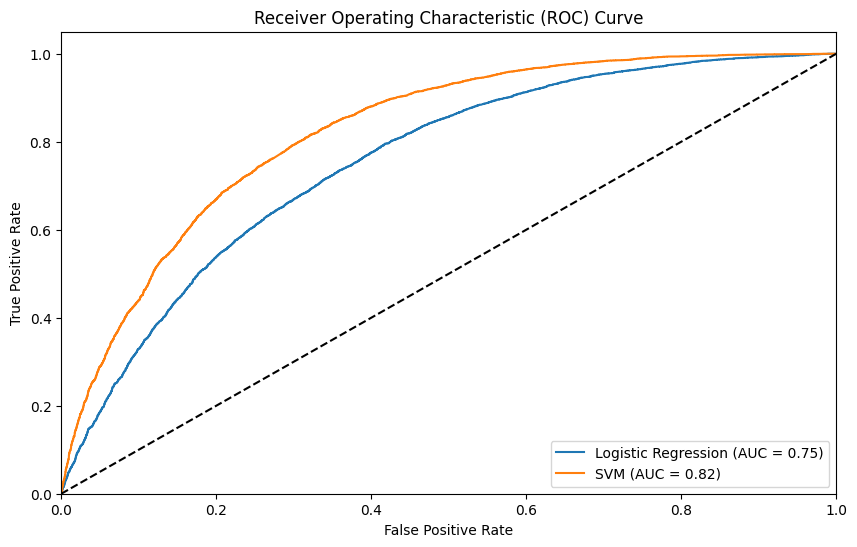

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

lr_prob = lr_model(X_test_tensor).detach().numpy().flatten()



logistic_fpr, logistic_tpr, _ = roc_curve(y_test, lr_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_metrics[4]:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_metrics[4]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Performnce Comparison Table

In [1]:
import pandas as pd

# Assuming logistic_metrics, logistic_ci, svm_metrics, svm_ci are predefined


# Creating the DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Sensitivity (Recall)', 'F1 Score', 'ROC AUC', 'True Positive (TP)', 'True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)'],
    'Logistic Regression': logistic_metrics,
    'Logistic Regression CI': [logistic_ci[metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']] + [None]*4,
    'SVM': svm_metrics,
    'SVM CI': [svm_ci[metric] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]  + [None]*4
})

# Set the Metric column as the index for better readability
comparison_df.set_index('Metric', inplace=True)

# Display the DataFrame
print(comparison_df.to_markdown())



NameError: name 'logistic_metrics' is not defined

In [4]:
import torch
print(torch.cuda.is_available())  # Check if CUDA is available

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.utils import resample
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Load the dataset
url = 'https://p19-bot-sign-sg.ciciai.com/tos-alisg-i-b2l6bve69y-sg/ca602a4dd2e04e6ea717f6548ca51fa6.csv~tplv-b2l6bve69y-image.image?rk3s=68e6b6b5&x-expires=1719744177&x-signature=sdxk9fyq5FsGMaG9rN5e5sU%2FFhk%3D'
data = pd.read_csv(url)

# Handling Missing Values
data.fillna(data.mean(), inplace=True)

# Encoding Categorical Variables
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# Normalizing Numerical Features
numerical_cols = data.columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the data to PyTorch tensors and move them to the GPU
X = torch.tensor(data.drop(columns=['Diabetes']).values, dtype=torch.float32).to(device)
y = torch.tensor(data['Diabetes'].values, dtype=torch.float32).view(-1, 1).to(device)

# Define the Logistic Regression model using PyTorch
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]
criterion = nn.BCELoss()

# Define number of epochs
num_epochs = 100

# Train the model
def train_model(model, optimizer, criterion, X_train, y_train):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')  # Debug statement
        loss.backward()
        optimizer.step()

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = outputs.round()
        y_test_numpy = y_test.cpu().numpy()  # Move to CPU for evaluation
        predicted_numpy = predicted.cpu().numpy()  # Move to CPU for evaluation
        y_prob = outputs.cpu().numpy()  # Move to CPU for evaluation

        # Calculate accuracy
        accuracy = accuracy_score(y_test_numpy, predicted_numpy)
        
        # Calculate precision
        precision = precision_score(y_test_numpy, predicted_numpy)
        
        # Calculate sensitivity (recall)
        recall = recall_score(y_test_numpy, predicted_numpy)
        
        # Calculate F1 score
        f1 = f1_score(y_test_numpy, predicted_numpy)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test_numpy, predicted_numpy).ravel()

        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test_numpy, y_prob)
        
        return accuracy, precision, recall, f1, roc_auc, tn, fp, fn, tp

# Perform 100 evaluations using bootstrapping
num_evaluations = 100
metrics = []

for i in range(num_evaluations):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X, y, n_samples=len(X), random_state=None)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=None)
    
    # Debug statements to check data
    print(f'Iteration {i+1}/{num_evaluations}')
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    
    # Reinitialize the model parameters for each iteration
    lr_model = LogisticRegressionModel(input_dim).to(device)
    optimizer = optim.SGD(lr_model.parameters(), lr=0.01)
    
    # Train the model
    train_model(lr_model, optimizer, criterion, X_train, y_train)
    
    # Evaluate the model
    metrics.append(evaluate_model(lr_model, X_test, y_test))
    
    # Save the model
    torch.save(lr_model.state_dict(), f'logistic_regression_model_{i}.pth')

# Calculate average metrics
metrics_array = np.array(metrics)
mean_metrics = np.mean(metrics_array, axis=0)

# Print the average results
print(f'Average Accuracy: {mean_metrics[0]:.4f}')
print(f'Average Precision: {mean_metrics[1]:.4f}')
print(f'Average Sensitivity (Recall): {mean_metrics[2]:.4f}')
print(f'Average F1 Score: {mean_metrics[3]:.4f}')
print(f'Average ROC AUC: {mean_metrics[4]:.4f}')
print(f'Average Confusion Matrix: TP={mean_metrics[8]:.0f}, TN={mean_metrics[5]:.0f}, FP={mean_metrics[6]:.0f}, FN={mean_metrics[7]:.0f}')

# Calculate mean and 95% confidence intervals for each metric
ci_lower = np.percentile(metrics_array, 2.5, axis=0)
ci_upper = np.percentile(metrics_array, 97.5, axis=0)

# Print the average results with confidence intervals
print(f'Average Accuracy: {mean_metrics[0]:.4f} (95% CI: {ci_lower[0]:.4f} - {ci_upper[0]:.4f})')
print(f'Average Precision: {mean_metrics[1]:.4f} (95% CI: {ci_lower[1]:.4f} - {ci_upper[1]:.4f})')
print(f'Average Sensitivity (Recall): {mean_metrics[2]:.4f} (95% CI: {ci_lower[2]:.4f} - {ci_upper[2]:.4f})')
print(f'Average F1 Score: {mean_metrics[3]:.4f} (95% CI: {ci_lower[3]:.4f} - {ci_upper[3]:.4f})')
print(f'Average ROC AUC: {mean_metrics[4]:.4f} (95% CI: {ci_lower[4]:.4f} - {ci_upper[4]:.4f})')
print(f'Average Confusion Matrix: TP={mean_metrics[8]:.0f} (95% CI: {ci_lower[8]:.0f} - {ci_upper[8]:.0f}), TN={mean_metrics[5]:.0f} (95% CI: {ci_lower[5]:.0f} - {ci_upper[5]:.0f}), FP={mean_metrics[6]:.0f} (95% CI: {ci_lower[6]:.0f} - {ci_upper[6]:.0f}), FN={mean_metrics[7]:.0f} (95% CI: {ci_lower[7]:.0f} - {ci_upper[7]:.0f})')


False
Iteration 1/100
X_train shape: torch.Size([56553, 17]), y_train shape: torch.Size([56553, 1])
X_test shape: torch.Size([14139, 17]), y_test shape: torch.Size([14139, 1])


RuntimeError: all elements of target should be between 0 and 1

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
import tensorflow as tf

# Assume data is already preprocessed
# Preprocessing code here...

# Sampling
X = data.drop(columns=['Diabetes'])
y = data['Diabetes']
y = y.apply(lambda x: 1 if x > 0 else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

# Define the Logistic Regression model using TensorFlow
class LogisticRegressionModel(tf.keras.Model):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        return self.linear(inputs)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
lr_model = LogisticRegressionModel(input_dim)
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Define the training function
def train_model(X_train, y_train, epochs=100):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            logits = lr_model(X_train)
            loss = binary_crossentropy(y_train, logits)
            regularization_loss = tf.reduce_sum(lr_model.losses)
            total_loss = loss + regularization_loss
        
        gradients = tape.gradient(total_loss, lr_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, lr_model.trainable_variables))
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.numpy():.4f}')

# Define the evaluation function
def evaluate_model(X_test, y_test):
    logits = lr_model(X_test)
    predictions = tf.round(logits)
    predictions = tf.squeeze(predictions)
    y_test_numpy = y_test.numpy()
    predictions_numpy = predictions.numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_numpy, predictions_numpy)
    
    # Calculate precision
    precision = precision_score(y_test_numpy, predictions_numpy)
    
    # Calculate sensitivity (recall)
    recall = recall_score(y_test_numpy, predictions_numpy)
    
    # Calculate F1 score
    f1 = f1_score(y_test_numpy, predictions_numpy)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test_numpy, predictions_numpy).ravel()

    # Calculate ROC AUC
    probabilities = logits.numpy()
    roc_auc = roc_auc_score(y_test_numpy, probabilities)
    
    return accuracy, precision, recall, f1, roc_auc, tn, fp, fn, tp

# Perform 100 evaluations using bootstrapping
num_evaluations = 100
metrics = []

for _ in range(num_evaluations):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_train, y_train, n_samples=len(X_train), random_state=None)
    
    # Convert resampled data to TensorFlow tensors
    X_resampled_tensor = tf.convert_to_tensor(X_resampled, dtype=tf.float32)
    y_resampled_tensor = tf.convert_to_tensor(y_resampled.values, dtype=tf.float32)
    
    # Reinitialize the model, optimizer, and loss function for each iteration
    lr_model = LogisticRegressionModel(input_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    # Train the model
    train_model(X_resampled_tensor, y_resampled_tensor)
    
    # Evaluate the model
    metrics.append(evaluate_model(X_test_tensor, y_test_tensor))

# Calculate average metrics
metrics_array = np.array(metrics)
mean_metrics = np.mean(metrics_array, axis=0)

# Print the average results
print(f'Average Accuracy: {mean_metrics[0]:.4f}')
print(f'Average Precision: {mean_metrics[1]:.4f}')
print(f'Average Sensitivity (Recall): {mean_metrics[2]:.4f}')
print(f'Average F1 Score: {mean_metrics[3]:.4f}')
print(f'Average ROC AUC: {mean_metrics[4]:.4f}')
print(f'Average Confusion Matrix: TP={mean_metrics[8]:.0f}, TN={mean_metrics[5]:.0f}, FP={mean_metrics[6]:.0f}, FN={mean_metrics[7]:.0f}')

Epoch [10/100], Loss: 0.7392
Epoch [20/100], Loss: 0.6562
Epoch [30/100], Loss: 0.6066
Epoch [40/100], Loss: 0.5753
Epoch [50/100], Loss: 0.5558
Epoch [60/100], Loss: 0.5432
Epoch [70/100], Loss: 0.5350
Epoch [80/100], Loss: 0.5296
Epoch [90/100], Loss: 0.5260
Epoch [100/100], Loss: 0.5236
Epoch [10/100], Loss: 0.7476
Epoch [20/100], Loss: 0.6613
Epoch [30/100], Loss: 0.6112
Epoch [40/100], Loss: 0.5799
Epoch [50/100], Loss: 0.5592
Epoch [60/100], Loss: 0.5451
Epoch [70/100], Loss: 0.5355
Epoch [80/100], Loss: 0.5290
Epoch [90/100], Loss: 0.5248
Epoch [100/100], Loss: 0.5220
Epoch [10/100], Loss: 0.8490
Epoch [20/100], Loss: 0.7287
Epoch [30/100], Loss: 0.6531
Epoch [40/100], Loss: 0.6063
Epoch [50/100], Loss: 0.5770
Epoch [60/100], Loss: 0.5586
Epoch [70/100], Loss: 0.5470
Epoch [80/100], Loss: 0.5393
Epoch [90/100], Loss: 0.5342
Epoch [100/100], Loss: 0.5304
Epoch [10/100], Loss: 1.1575
Epoch [20/100], Loss: 0.9439
Epoch [30/100], Loss: 0.7923
Epoch [40/100], Loss: 0.6904
Epoch [50/1

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
import tensorflow as tf

# Assume data is already preprocessed
# Preprocessing code here...
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
url = 'https://p19-bot-sign-sg.ciciai.com/tos-alisg-i-b2l6bve69y-sg/ca602a4dd2e04e6ea717f6548ca51fa6.csv~tplv-b2l6bve69y-image.image?rk3s=68e6b6b5&x-expires=1719744177&x-signature=sdxk9fyq5FsGMaG9rN5e5sU%2FFhk%3D'
data = pd.read_csv(url)

# Handling Missing Values
data.fillna(data.mean(), inplace=True)

# Encoding Categorical Variables
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# Normalizing Numerical Features
numerical_cols = data.columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Sampling
X = data.drop(columns=['Diabetes'])
y = data['Diabetes']
y = y.apply(lambda x: 1 if x > 0 else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

# Define the SVM model using TensorFlow
class SVMModel(tf.keras.Model):
    def __init__(self, input_dim):
        super(SVMModel, self).__init__()
        self.linear = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))
    
    def call(self, inputs):
        return self.linear(inputs)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
svm_model = SVMModel(input_dim)
hinge_loss = tf.keras.losses.Hinge()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Define the training function
def train_model(X_train, y_train, epochs=100):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            logits = svm_model(X_train)
            loss = hinge_loss(2 * y_train - 1, logits)  # Convert 0/1 to -1/1
            regularization_loss = tf.reduce_sum(svm_model.losses)
            total_loss = loss + regularization_loss
        
        gradients = tape.gradient(total_loss, svm_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, svm_model.trainable_variables))
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.numpy():.4f}')

# Define the evaluation function
def evaluate_model(X_test, y_test):
    logits = svm_model(X_test)
    predictions = tf.sign(logits)
    predictions = tf.squeeze(predictions)
    y_test_numpy = y_test.numpy()
    predictions_numpy = (predictions.numpy() + 1) / 2  # Convert -1/1 to 0/1
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_numpy, predictions_numpy)
    
    # Calculate precision
    precision = precision_score(y_test_numpy, predictions_numpy)
    
    # Calculate sensitivity (recall)
    recall = recall_score(y_test_numpy, predictions_numpy)
    
    # Calculate F1 score
    f1 = f1_score(y_test_numpy, predictions_numpy)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test_numpy, predictions_numpy).ravel()

    # Calculate ROC AUC
    probabilities = tf.sigmoid(logits).numpy()
    roc_auc = roc_auc_score(y_test_numpy, probabilities)
    
    return accuracy, precision, recall, f1, roc_auc, tn, fp, fn, tp

# Perform 100 evaluations using bootstrapping
num_evaluations = 100
metrics = []

for _ in range(num_evaluations):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_train, y_train, n_samples=len(X_train), random_state=None)
    
    # Convert resampled data to TensorFlow tensors
    X_resampled_tensor = tf.convert_to_tensor(X_resampled, dtype=tf.float32)
    y_resampled_tensor = tf.convert_to_tensor(y_resampled.values, dtype=tf.float32)
    
    # Reinitialize the model, optimizer, and loss function for each iteration
    svm_model = SVMModel(input_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    # Train the model
    train_model(X_resampled_tensor, y_resampled_tensor)
    
    # Evaluate the model
    metrics.append(evaluate_model(X_test_tensor, y_test_tensor))

# Calculate average metrics
metrics_array = np.array(metrics)
mean_metrics = np.mean(metrics_array, axis=0)

# Print the average results
print(f'Average Accuracy: {mean_metrics[0]:.4f}')
print(f'Average Precision: {mean_metrics[1]:.4f}')
print(f'Average Sensitivity (Recall): {mean_metrics[2]:.4f}')
print(f'Average F1 Score: {mean_metrics[3]:.4f}')
print(f'Average ROC AUC: {mean_metrics[4]:.4f}')
print(f'Average Confusion Matrix: TP={mean_metrics[8]:.0f}, TN={mean_metrics[5]:.0f}, FP={mean_metrics[6]:.0f}, FN={mean_metrics[7]:.0f}')

Epoch [10/100], Loss: 1.2291
Epoch [20/100], Loss: 0.9861
Epoch [30/100], Loss: 0.8280
Epoch [40/100], Loss: 0.7406
Epoch [50/100], Loss: 0.6943
Epoch [60/100], Loss: 0.6669
Epoch [70/100], Loss: 0.6477
Epoch [80/100], Loss: 0.6336
Epoch [90/100], Loss: 0.6229
Epoch [100/100], Loss: 0.6148
Epoch [10/100], Loss: 1.2249
Epoch [20/100], Loss: 0.9788
Epoch [30/100], Loss: 0.8273
Epoch [40/100], Loss: 0.7500
Epoch [50/100], Loss: 0.7014
Epoch [60/100], Loss: 0.6680
Epoch [70/100], Loss: 0.6450
Epoch [80/100], Loss: 0.6289
Epoch [90/100], Loss: 0.6177
Epoch [100/100], Loss: 0.6099
Epoch [10/100], Loss: 0.8937
Epoch [20/100], Loss: 0.7719
Epoch [30/100], Loss: 0.6982
Epoch [40/100], Loss: 0.6559
Epoch [50/100], Loss: 0.6310
Epoch [60/100], Loss: 0.6144
Epoch [70/100], Loss: 0.6033
Epoch [80/100], Loss: 0.5964
Epoch [90/100], Loss: 0.5924
Epoch [100/100], Loss: 0.5901
Epoch [10/100], Loss: 0.8356
Epoch [20/100], Loss: 0.7373
Epoch [30/100], Loss: 0.6816
Epoch [40/100], Loss: 0.6450
Epoch [50/1

In [33]:
#release gpu memory
import torch
torch.cuda.empty_cache()

#release gpu memory(tensorflow)
import tensorflow as tf
tf.keras.backend.clear_session()